In [1]:
%pip install -q mediapipe


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

UsageError: Line magic function `%wget` not found.


## Use Google's Mediapipe model for body point landmark detection

In [3]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

### Run Inference

In [4]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from matplotlib import pyplot as plt

def detect_points(image_path):

    # STEP 2: Create an PoseLandmarker object.
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)

    # STEP 3: Load the input image.
    image = mp.Image.create_from_file(image_path)

    # STEP 4: Detect pose landmarks from the input image.
    detection_result = detector.detect(image)

    # STEP 5: Process the detection result. In this case, visualize it.
    image_bgr = cv2.cvtColor(image.numpy_view(), cv2.COLOR_RGB2BGR)
    annotated_image = draw_landmarks_on_image(image_bgr, detection_result)
    

    # plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

    return annotated_image

## Similarity computation

In [6]:
from PIL import Image

def resize_image(image_path, max_width=640, max_height=480):
    try:
        with Image.open(image_path) as img:
            if img.mode != "RGB":
                img = img.convert("RGB")
            img.thumbnail((max_width, max_height))
            return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

### Normalization + Similarity

I0000 00:00:1733782751.566960 11043975 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83), renderer: Apple M1
W0000 00:00:1733782751.678360 11044931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733782751.752047 11044933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733782751.957339 11044929 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


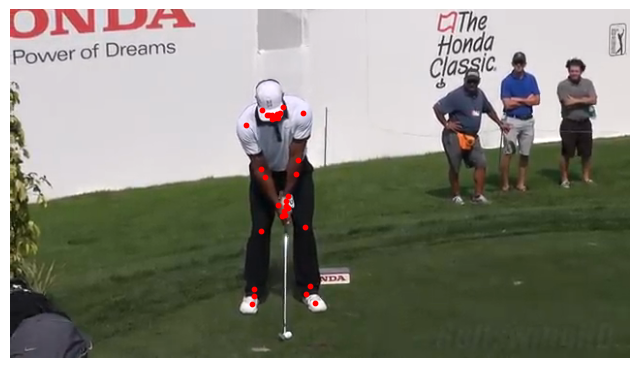

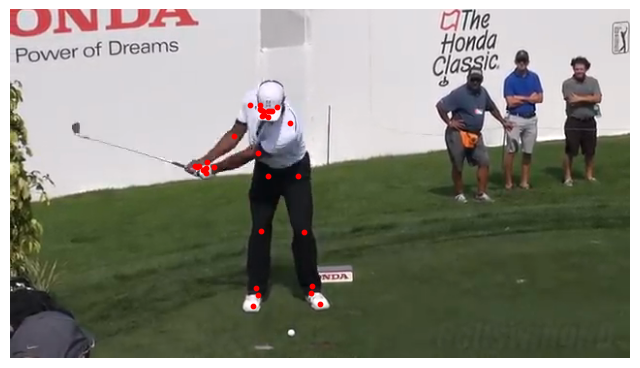

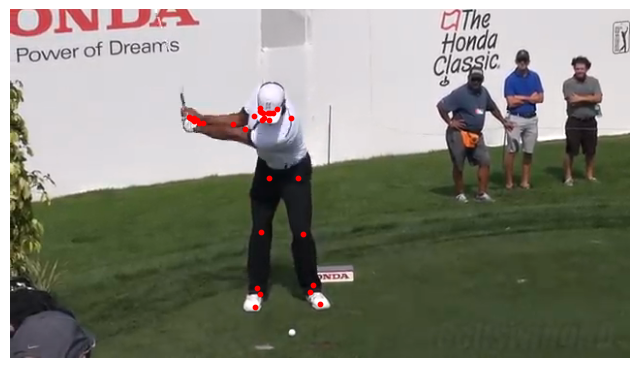

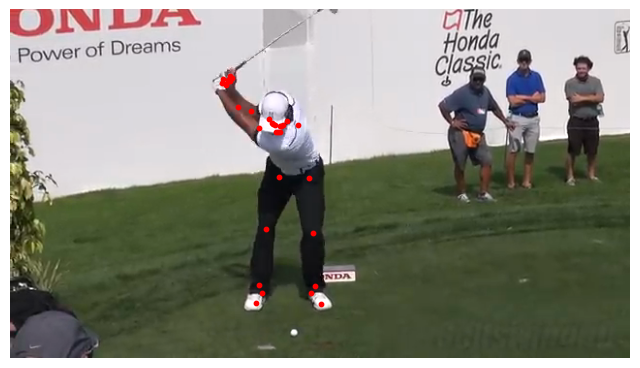

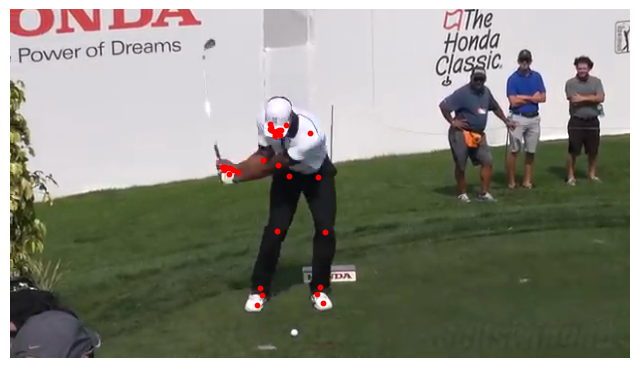

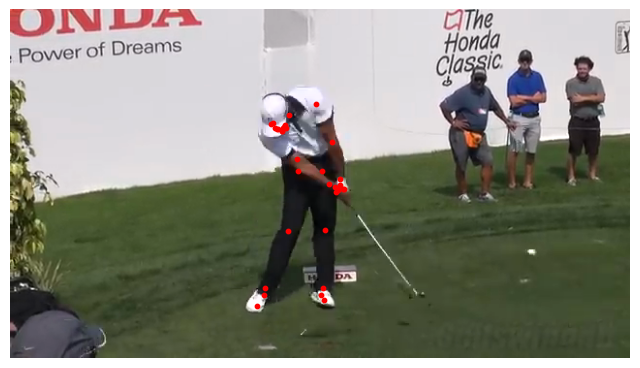

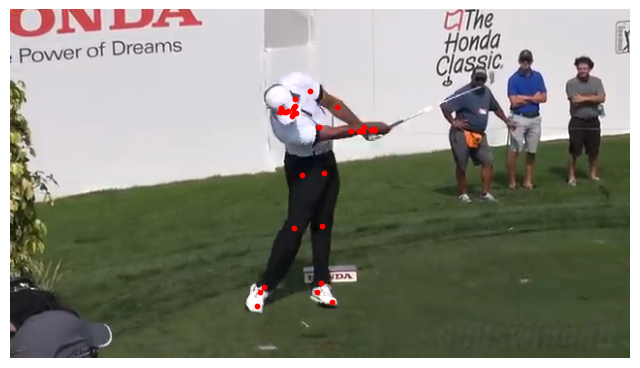

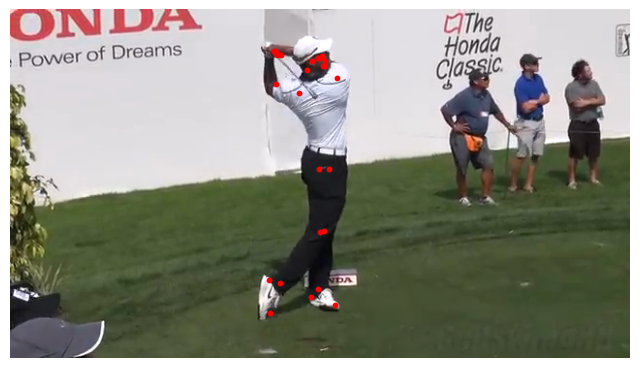

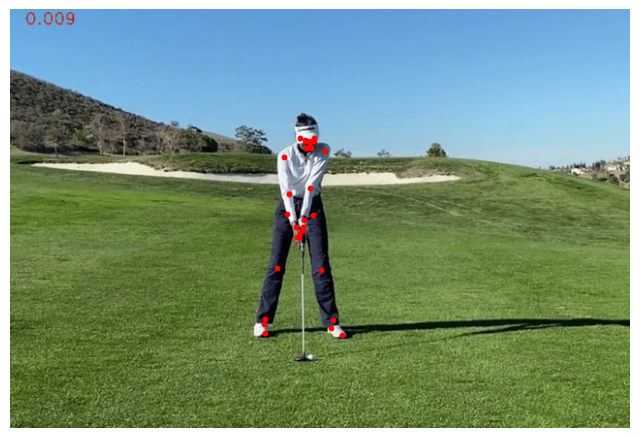

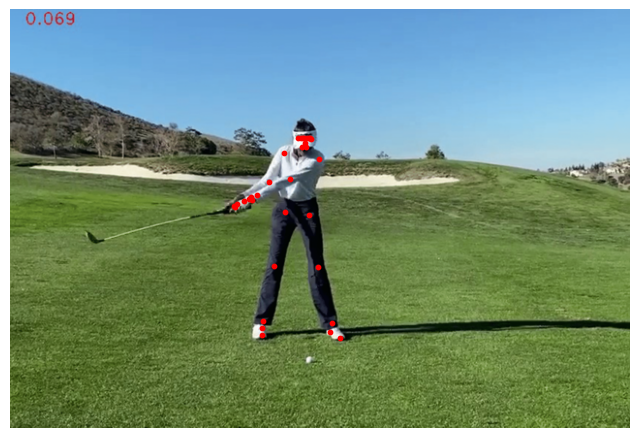

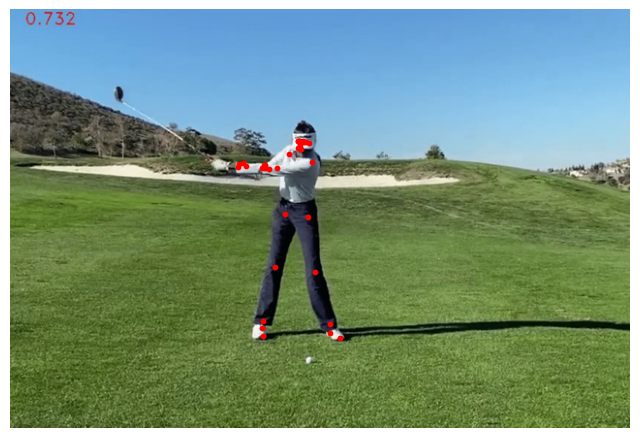

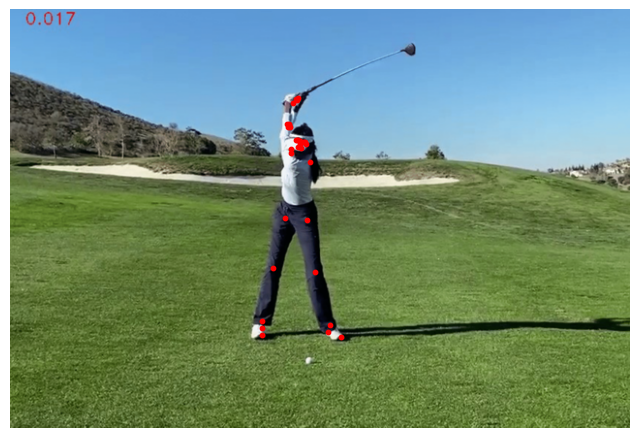

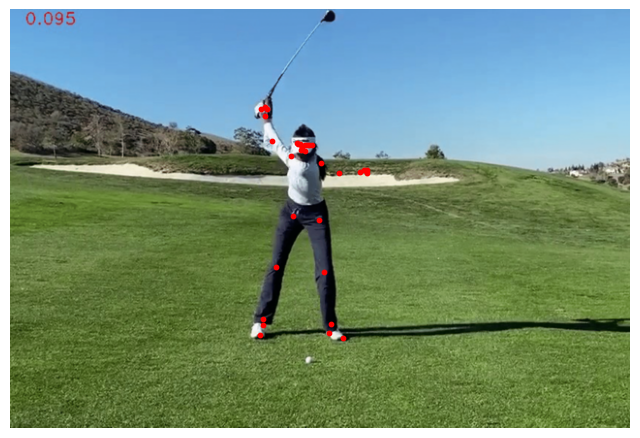

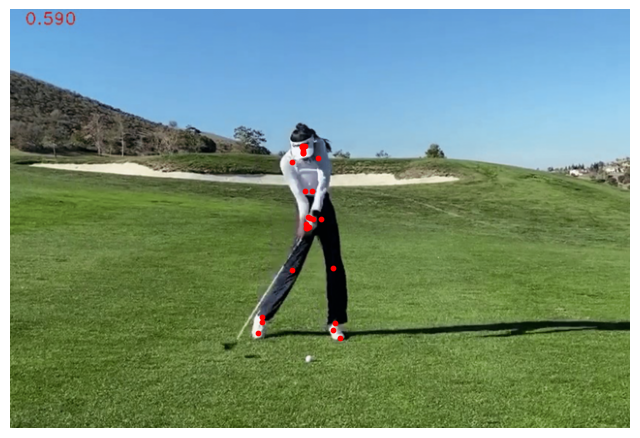

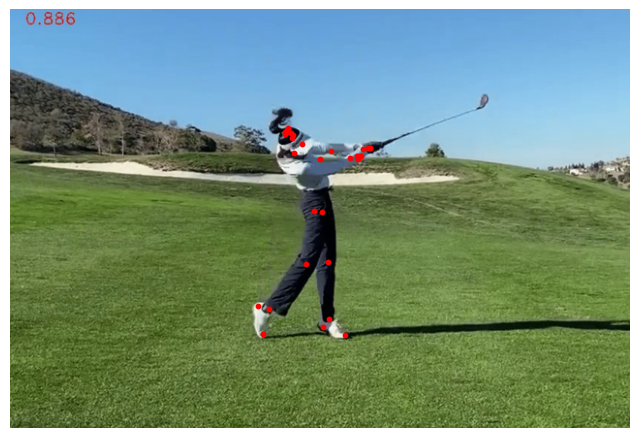

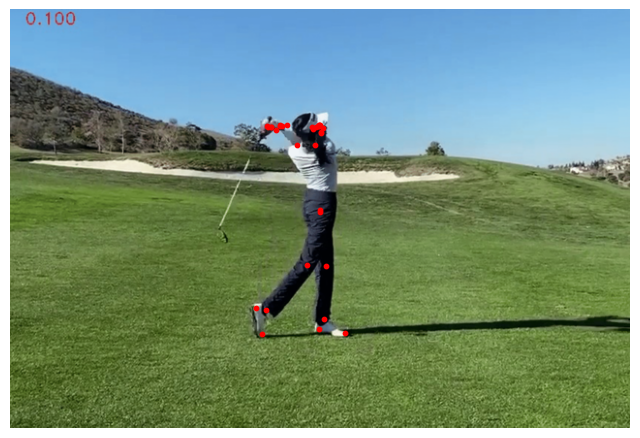

Address similarity: 0.9854537180947334
Toe-up similarity: 0.9747107181851508
Mid-backswing (arm parallel) similarity: 0.8715035401378609
Top similarity: 0.6081948759667679
Mid-downswing (arm parallel) similarity: 0.8692683632860111
Impact similarity: 0.9176701874826657
Mid-followthrough (shaft parallel) similarity: 0.8678727613640035
Finish similarity: 0.6590817489813576
Overall similarity: 0.8442194891873188


In [7]:
import numpy as np
from scipy.spatial.distance import euclidean
import mediapipe as mp
import os

# make sure you're passing in only the KEY frames from the frames directory
# loop through videos in frame directory, using tiger woods v sohini for example
sample_vid_dir = "../frames/21"
comparison_vid_dir = "../sohini_swing"

# define frame img names
pos_names = ["Address", "Toe-up", "Mid-backswing (arm parallel)", "Top", "Mid-downswing (arm parallel)", "Impact", "Mid-followthrough (shaft parallel)", "Finish"]

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# get keypoints from mediapipe detection
def extract_keypoints(detection_result):
    pose_landmarks = detection_result.pose_landmarks[0]
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks])

def normalize_keypoints(keypoints):
    # nose as reference point
    reference_point = keypoints[0]
    
    # norm all keypoints around nose point
    normalized = keypoints - reference_point
    
    left_shoulder = keypoints[11]
    right_shoulder = keypoints[12]
    scale = np.linalg.norm(left_shoulder - right_shoulder)
    
    normalized /= scale
    
    return normalized

# p4ocrustes analysis
def calculate_procrustes_distance(keypoints1, keypoints2):
    # center
    keypoints1 -= np.mean(keypoints1, axis=0)
    keypoints2 -= np.mean(keypoints2, axis=0)
    
    # normalize
    keypoints1 /= np.linalg.norm(keypoints1)
    keypoints2 /= np.linalg.norm(keypoints2)
    
    # sing value decomposition
    U, _, Vt = np.linalg.svd(keypoints1.T @ keypoints2)
    R = U @ Vt
    
    keypoints1_rotated = keypoints1 @ R
    
    return np.sum(np.square(keypoints1_rotated - keypoints2))

def compare_keypoints(sample_keypoints, comparison_keypoints):
    return 1 / (1 + calculate_procrustes_distance(sample_keypoints, comparison_keypoints))

def display_image_with_keypoints(image, keypoints):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    for keypoint in keypoints:
        plt.scatter(keypoint[0] * image.shape[1], keypoint[1] * image.shape[0], c='red', s=10)
    plt.axis('off')
    plt.show()

def process_frames(vid_dir):
    processed_frames = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
    for frame in sorted(os.listdir(vid_dir)):
        if frame.lower().endswith(valid_extensions):
            img_path = os.path.join(vid_dir, frame)
            try:
                resized_img = resize_image(img_path)
                if resized_img is not None:
                    np_image = np.array(resized_img)
                    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=np_image)
                    detection_result = detector.detect(mp_image)
                    keypoints = extract_keypoints(detection_result)
                    normalized_keypoints = normalize_keypoints(keypoints)
                    processed_frames.append(normalized_keypoints)

                    # optionally display the image with keypoints
                    display_image_with_keypoints(np_image, keypoints)
            except Exception as e:
                print(f"Error processing frame {frame}: {e}")
    return processed_frames

sample_frames = process_frames(sample_vid_dir)
comparison_frames = process_frames(comparison_vid_dir)

# compute similarities
similarities = []
for sample, comparison in zip(sample_frames, comparison_frames):
    similarity = compare_keypoints(sample, comparison)
    similarities.append(similarity)

for i, similarity in enumerate(similarities):
    print(f"{pos_names[i]} similarity: {similarity}")

overall_similarity = np.mean(similarities)
print(f"Overall similarity: {overall_similarity}")

## Plot similarity with Key Frames

I0000 00:00:1733790050.726687 11043975 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83), renderer: Apple M1
W0000 00:00:1733790050.836431 11105036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733790050.913309 11105037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733790051.082800 11043975 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83), renderer: Apple M1
W0000 00:00:1733790051.192547 11105046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733790051.253062 11105049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733790051.435961 11043975 gl_cont

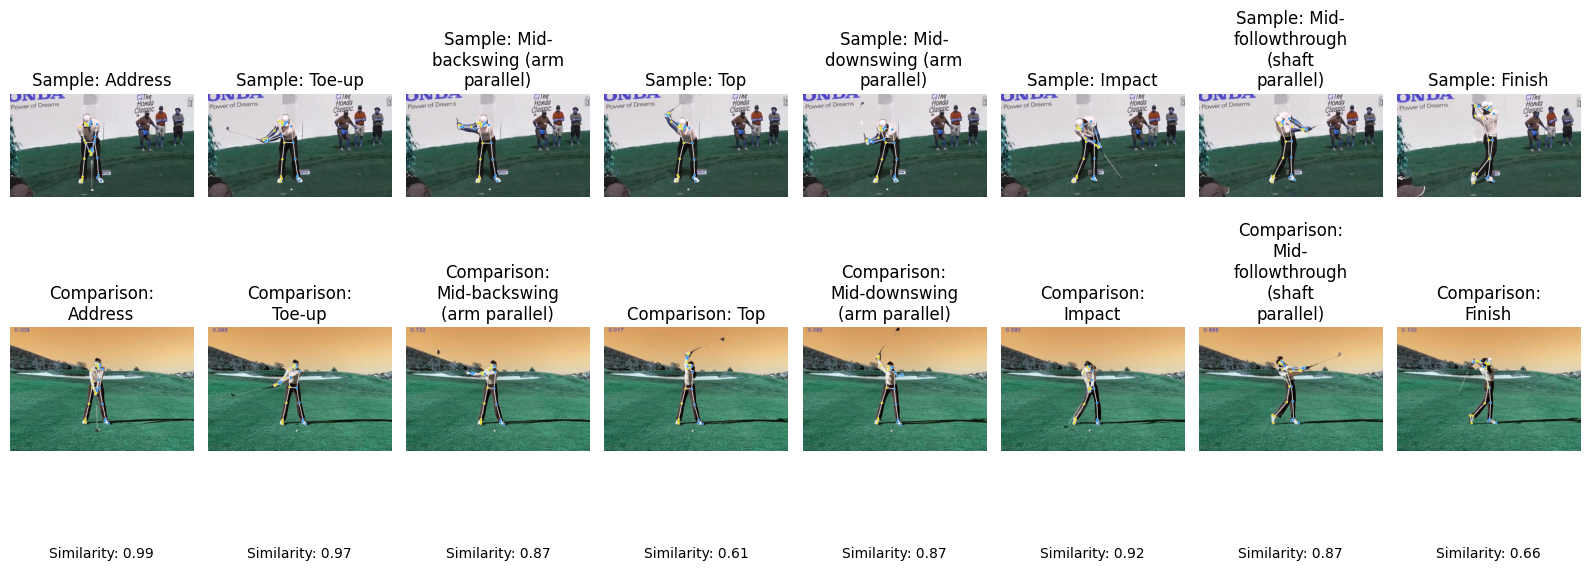

In [36]:
import os
import textwrap

def get_frame_points(vid_dir):
    annotated_images = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp') 
    for frame in sorted(os.listdir(vid_dir)):
        if frame.lower().endswith(valid_extensions):
            img_path = f"{vid_dir}/{frame}"
            resized_img = resize_image(img_path)
            resized_img.save("temp_resized_image.jpg")
            anno_img = detect_points("temp_resized_image.jpg")
            # anno_img = detect_points(img_path)
            annotated_images.append(anno_img)
    return annotated_images

sample_points = get_frame_points(sample_vid_dir)
comparison_points = get_frame_points(comparison_vid_dir)

num_frames = len(sample_points)
fig, axes = plt.subplots(3, num_frames, figsize=(num_frames * 2, 6), 
                         gridspec_kw={'height_ratios': [1, 1, 0.2]})

for i in range(num_frames):
    # sample points
    ax_top = axes[0, i]
    ax_top.imshow(sample_points[i])
    ax_top.axis('off')
    wrapped_title = "\n".join(textwrap.wrap(f"Sample: {pos_names[i]}", width=15))
    ax_top.set_title(wrapped_title)
    
    # comparison points
    ax_middle = axes[1, i]
    ax_middle.imshow(comparison_points[i])
    ax_middle.axis('off')
    wrapped_title = "\n".join(textwrap.wrap(f"Comparison: {pos_names[i]}", width=15))
    ax_middle.set_title(wrapped_title)
    
    # similarity scores
    ax_bottom = axes[2, i]
    ax_bottom.axis('off')
    ax_bottom.text(0.5, 0.5, f"Similarity: {similarities[i]:.2f}", 
                   ha='center', va='center')

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()